# Machine Learning for SETs
### Berkay Dean 

## Libraries Needed

In [11]:
## Needed Libraries and Clear Vars
%reset -f
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from Machine_Learning_Functions import *
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scipy import stats
from scipy.stats import kurtosis
from scipy.stats import skew
import seaborn as sb
from ipywidgets import interactive
import time
from math import log
from sklearn.decomposition import PCA

## Function Declerations
In the block below, a few generalized functions are declared for easier coding

In [12]:
## This file contains a few generalized functions for making
## running machine learning for SETs more streamlined

## Funtion for getting dataframe to only node magnitude and pulse width
def df_cleanup(df):
    df.sort_values(by=['Node'], inplace=True)

    # # Label Encoder is used to encode Nodes (strings) into values between 0 and 
    # # n_classes - 1
    le = preprocessing.LabelEncoder()
    le.fit(df["Node"])
    df["Node"] = le.transform(df["Node"])

    new_df = df.drop(["Bias 1", "Bias 2", "Number of Transients", "Deposited_Q",\
          "Mean", "Variance", "Standard Deviation", "Skew", "Kurtosis"], axis=1)

    new_df['Magnitude'] = new_df['Magnitude'].astype(float, errors='raise')
    new_df['Pulse Width'] = new_df['Pulse Width'].astype(float, errors='raise')
    
    return new_df


## Function for Printing Column of Coorelation Matrix
def print_corr(dataframe, column):
    print(dataframe.corr()[column] )


## Function for splitting up testing and training material
## and splitting node to be classified from the rest
def training_split(dataframe, column, test_size, random_state):
    
    X = dataframe.drop(column, axis=1)
    y = dataframe[column]

    ## Convert datafram to array
    X = X.to_numpy()
    y = y.to_numpy()
    # print(y)
    # print(le.inverse_transform(y))

    ## Scale values
    X = preprocessing.scale(X)

    

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=1234)
    
    return  (X, y, X_train, X_test, y_train, y_test)


## kNN Model Initialization and Run
def kNN_initialization(n_neighbors, X_train, y_train, X_test, y_test):
    

    ## Initialize knn model with arbitrary n_neighbors (k) value
    # Maybe use unsupervised version?
    knn = KNeighborsClassifier(n_neighbors)

    ## Fit kNN
    knn.fit(X_train, y_train)

    ## predict y_test value using fitted mode
    y_pred = knn.predict(X_test)
    #plot_confusion_matrix(knn, X_test, y_test)

    ## Print accuracy of kNN
    print("Initial kNN Accuracy:",metrics.accuracy_score(y_test, y_pred))
    return knn


## kNN Model Optimization using GridSearchCV
def gridSearchCV_Optimization(largest_n_neighbors, X_train, y_train, X_test, y_test):
    parameters = {"n_neighbors": range(1, largest_n_neighbors),
        "weights": ["uniform", "distance"]}
    gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
    gridsearch.fit(X_train, y_train)
    print(gridsearch.best_params_)
    test_preds_grid = gridsearch.predict(X_test)
    print("Optimized Accuracy:",metrics.accuracy_score(y_test, test_preds_grid))
    return gridsearch

## Jake's IRES Function
def vectorized_stride_v2(array, clearing_time_index, max_time, sub_window_size,
                         stride_size):
    start = clearing_time_index + 1 - sub_window_size - 1
    
    sub_windows = (
        start + 
        np.expand_dims(np.arange(sub_window_size), 0) +
        np.expand_dims(np.arange(max_time + 1, step=stride_size), 0) .T
    )
    
    Mean = np.mean(array[sub_windows,0], +1)
    M = np.array([Mean])
    max_mean = np.amax(M)
   # M_norm = np.linalg.norm(M)
   # M = M/M_norm
   
    Var = np.var(array[sub_windows,0], +1)
    V = np.array([Var])
    max_var = np.amax(V)
    #V_norm = np.linalg.norm(V)
   # V = V/V_norm

    St_Dev = np.std(array[sub_windows,0], +1)
    SD = np.array([St_Dev])
    max_std = np.amax(SD)
   # SD_norm = np.linalg.norm(SD)
   # SD = SD/SD_norm

    Skew = skew(array[sub_windows,0], +1)
    S = np.array([Skew])
    max_skew = np.amax(S)
    #S_norm = np.linalg.norm(S)
   # S = S/S_norm

    Kur =  kurtosis(array[sub_windows,0], +1)
    K = np.array([Kur])
    max_kur = np.amax(K)
   # K_norm = np.linalg.norm(K)
   # K = K/K_norm

    max_stats =[max_mean, max_var, max_std, max_skew, max_kur]
    
    # m = np.concatenate([M, V, SD, S, K])
    # for i in range (len(m)):
    #     offset = [min(m[i])] * len(m[i])
    #     m[i] = (m[i]-offset)
    #     norm = [max(m[i])]*len(m[i])
    #     m[i] = m[i]/norm
    # m = m .T
    return  max_stats

def decay_const(df_exp):
    df_exp = df_exp[['time', 'vout']]
    vout_col = df_exp['vout']

    ## Max value of vout
    peak = vout_col.max()

    ## Time at max value
    t_peak = df_exp.loc[df_exp['vout'] == peak, 'time'].iloc[0]

    ## get fwhm function 
    half_max = peak/2
    

    ## finding half max value
    index = df_exp.index[df_exp['vout'] == peak].tolist()
    df_exp_2 = df_exp[index[0]:len(df_exp)]

    exists = df_exp_2['vout'].between(0, half_max, inclusive=True).any()
    if exists == False:
        tau = 0
        return tau
    
    t_half_max = df_exp_2.loc[df_exp_2['vout'] <= half_max, 'time'].iloc[0]

    ## decay constant calculation for half-life
    t_diff = t_peak - t_half_max
    tau = (-1*log(2))/t_diff

    return tau


## Data Extraction
In the below subsection, data is extracted from simulation files

In [13]:
# filenames = sorted(glob.glob('LM124_sim_SET1_ASET_QR_*.raw'))
#filenames = sorted(glob.glob('sim_data\LM124_sim_SET1_ASET_*'))
#print(filenames)
filenames = sorted(glob.glob('G:\Shared drives\Research Simulation Data\\NPN sim\LM124_sim_SET1_ASET_*'))
## Use numpy array instead of list because arrays are more 
## efficient for large amounts of data
D = np.zeros((7,), dtype=int)
for filename in filenames:
    new_row = np.array([])
    #print(filename)
    with open(filename, 'rt') as myfile:
        for line in myfile:
            #print(line)
            new_row = np.concatenate( (new_row, [line]))

    ## get strings ready to be turned to floats
    new_row = [s.replace("\n", "") for s in new_row]
    new_row = [s.replace("[", "") for s in new_row]
    new_row = [s.replace("]", "") for s in new_row]
    new_row[5] = new_row[5].partition(",")[0]
    #print(new_row)

    ##make new list of floats
    for i in range(1, len(new_row)):
        new_row[i] = float(new_row[i])
    #print(new_row)

    ## This Block of code seperates the node and deposited charge for dataframe
    new_row[0] = new_row[0].partition('SET2_')[2]
    #print(new_row[0])
    Node = new_row[0].partition("_")[0]
    #print(Node)
    dep_charge = new_row[0].partition("_")[2]
    dep_charge = dep_charge.partition("m")[0]
    #print(dep_charge)
    new_row = np.delete(new_row, 0, 0)
    new_row = np.insert(new_row, 0, dep_charge)
    new_row = np.insert(new_row, 0, Node)

    # stack new rows on to other rows
    D = np.vstack([D, new_row])
    #print(D.shape)

## Block for extracting IRES stats
filenames = sorted(glob.glob('G:\Shared drives\Research Simulation Data\\NPN sim\LM124_sim_SET2_*.sorted')) #change file name  
filenames = filenames[0:400]
max_stats = np.zeros((6,), dtype=int)
for filename in filenames:
    D2 = np.loadtxt(fname=filename,dtype=np.float64)
    cols = ["val", "time", "vout", "vin"]
    df = pd.DataFrame(D2,columns=cols)
    # decay constant calculation
    tau = decay_const(df)

    y = df[['vout']]
    max_val = max(df['val'])
    max_val = int(max_val)
    df = df.drop(columns=['vin', 'time', 'val'])
    df = df.to_numpy()
    new_max_stats = vectorized_stride_v2(df, 0, max_val, 5, 1)
    
    new_max_stats.append(tau)
    max_stats = np.vstack([max_stats, new_max_stats])

    ######################## Commented out portion is plotting IRES Spectrograms
    #def plotting (sub_window_size = 10000, stride_size = 1000):    
    #b = np.array(b)
    #print(b)
    # cols = ['MEAN', 'VARIANCE', 'STANDARD DEV', 'SKEWNESS', 'KURTOSIS']
    # dk = pd.DataFrame(max_stats, columns=cols)
    # #print(dk)
    # #dk = dk.to_numpy()
    # grid = dict(width_ratios=[30,1],height_ratios=[5,1])
    # fig,ax = plt.subplots(2,2,gridspec_kw=grid)
    # cm = ax[0][0].pcolor(dk.T, cmap = 'rainbow')
    # ax[1][0].plot(y)
    # ax[1][0].margins(x=0)
    # ax[1][1].axis('off')
    # ax[0][0].set_yticks(range(len(dk.columns)))
    # ax[0][0].set_yticklabels(dk.columns)
    # ax[0][0].set_title(filename)
    # #plt.xticks(range(len(dk.index)), dk.index)
    # # ax1.set_yticks(range(len(dk.columns)), dk.columns)
    # #plt.figure(figsize=(5, 10))
    # plt.colorbar(cm,cax=ax[0][1],ax=ax[0][0])
    # plt.show()
    #interactive_plot = interactive (plotting, sub_window_size = (10,100000,100) , stride_size = (10,100000,100) )


########## Organize dataframe
max_stats = np.delete(max_stats, (0), axis=0)
D = np.delete(D, (0), axis=0)
D = np.concatenate((D, max_stats), axis=1)
#print(D)
cols = ["Node", "Deposited_Q" ,"Bias 1", "Bias 2", "Number of Transients", "Magnitude", "Pulse Width", \
    "Mean", "Variance", "Standard Deviation", "Skew", "Kurtosis", "Tau"]
df = pd.DataFrame(D,columns=cols)
#print(df.head)
    # df = df.set_index(df['time'])
    # df[['vout']].plot ()
    # plt.ylabel('Voltage (V)')
    # plt.xlabel('Time (s)')
    # plt.title(filename)
    # plt.show()

## Machine Learning Data Preperation
In the following section, the data is manipulated and prepared for the machine learning algorithm, kNN

In [14]:
## Clean dataframe for this specific project
#df2 = df_cleanup(df)

df.sort_values(by=['Node'], inplace=True)

# # Label Encoder is used to encode Nodes (strings) into values between 0 and 
# # n_classes - 1
le = preprocessing.LabelEncoder()
le.fit(df["Node"])
df["Node"] = le.transform(df["Node"])

#df2 = df.drop(["Bias 1", "Bias 2", "Number of Transients", "Deposited_Q",\
 #       "Mean", "Variance", "Standard Deviation", "Skew", "Kurtosis"], axis=1)
df2 = df.drop(["Bias 1", "Bias 2", "Number of Transients", "Deposited_Q"], axis=1)

df2 = df2.astype(float, errors='raise')

## Coorelation Matrix - What values have good coorelation with Node value
## Enter dataframe you are using, and the nod you want to coorelate
print_corr(df2, "Node")

df2 = df2.drop(['Skew', 'Kurtosis'], axis=1)

Node                  1.000000
Magnitude             0.392168
Pulse Width           0.313858
Mean                  0.390955
Variance              0.441863
Standard Deviation    0.443252
Skew                  0.046394
Kurtosis             -0.133690
Tau                   0.103267
Name: Node, dtype: float64


## Create Training and Testing Set using sklearn
test_size represents the proportion of the data set to test on
random_state randomizes the set, number is arbitrary

In [15]:
## Enter Dataframe used for ML, the Variable you are classifying
## the size of the testing portion, and a random_state (arbitrary)
X, y, X_train, X_test, y_train, y_test = training_split(df2, "Node", test_size=0.25, random_state=1234)

## Initialize and train initial kNN Model
Note accuracy is 0.5 because it is essentially guessing

In [16]:
## initialize the number of neighbors to use, and input the values 
## produced by the training_split function
n_neighbors = 5
kNN_initialization(n_neighbors, X_train, y_train, X_test, y_test)

Initial kNN Accuracy: 0.5441176470588235


KNeighborsClassifier()

## Optimization of kNN Model using GridSearchCV
Exhaustive search over specified parameter values for an estimator

In [17]:
## largest_n_neighbors: largest value for the gridsearch to search among
## ex: 25 -> gridsearch tries all n_neighbors from 1 to 25 and chooses value that gives highest accuracy
largest_n_neighbors = 25
gridSearchCV_Optimization(largest_n_neighbors, X_train, y_train, X_test, y_test)

{'n_neighbors': 4, 'weights': 'distance'}
Optimized Accuracy: 0.5294117647058824


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 25),
                         'weights': ['uniform', 'distance']})

## Updating Dataframe so that no "0" Values are included

In [18]:
df3 = df2[ df2.Magnitude > 1e-9 ]

print_corr(df3, "Node")

X, y, X_train, X_test, y_train, y_test = training_split(df3, "Node", test_size=0.25, random_state=1234)

n_neighbors = 10
knn = kNN_initialization(n_neighbors, X_train, y_train, X_test, y_test)

largest_n_neighbors = 25
gridsearch_knn = gridSearchCV_Optimization(largest_n_neighbors, X_train, y_train, X_test, y_test)


Node                  1.000000
Magnitude             0.499412
Pulse Width           0.397345
Mean                  0.496839
Variance              0.529392
Standard Deviation    0.551031
Tau                  -0.039117
Name: Node, dtype: float64
Initial kNN Accuracy: 0.56
{'n_neighbors': 10, 'weights': 'distance'}
Optimized Accuracy: 0.62


## Making dataframe for each deposited charge and performing ml on those


In [19]:
# df_1m = df[ df.Deposited_Q == '1' ]
# df_1m = df_cleanup(df_1m)
# df_1m = df_1m[ df_1m.Magnitude > 1e-9 ]

# X_train, X_test, y_train, y_test = training_split(df_1m, "Node", test_size=0.25, random_state=1234)

# n_neighbors = 5
# kNN_initialization(n_neighbors, X_train, y_train, X_test, y_test)

# largest_n_neighbors = 9
# gridSearchCV_Optimization(largest_n_neighbors, X_train, y_train, X_test, y_test)

# PCA (Principle Component Analysis) for visualization

In [20]:
# pca = PCA(n_components=2)
# X_train_pca = pca.fit_transform(X_train)

# knn_pca = KNeighborsClassifier(n_neighbors)

# ## Fit kNN
# knn_pca.fit(X_train_pca, y_train)

# parameters = {"n_neighbors": range(1, largest_n_neighbors),
#     "weights": ["uniform", "distance"]}
# gridsearch_pca = GridSearchCV(KNeighborsClassifier(), parameters)
# gridsearch_pca.fit(X_train_pca, y_train)

# from mlxtend.plotting import plot_decision_regions
# fig, axes = plt.subplots(1, 2, figsize=(11, 4))

# fig1 = plot_decision_regions(X=X_train_pca, y=y_train.astype(np.int32), clf=knn_pca, ax=axes[0], legend=1)
# fig2 = plot_decision_regions(X=X_train_pca, y=y_train.astype(np.int32), clf=gridsearch_pca, ax=axes[1], legend=1)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 25),
                         'weights': ['uniform', 'distance']})

# Plotting Decision Regions

C:\Users\berka\miniconda3\envs\ml1\lib\site-packages\mlxtend\plotting\decision_regions.py:280: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  **scatter_kwargs)
C:\Users\berka\miniconda3\envs\ml1\lib\site-packages\mlxtend\plotting\decision_regions.py:280: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  **scatter_kwargs)


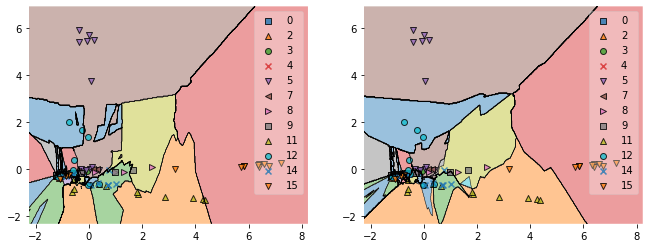

In [23]:
from mlxtend.plotting import plot_decision_regions
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

fig1 = plot_decision_regions(X=X, y=y.astype(np.int32), clf=knn_pca, ax=axes[0], legend=1)
fig2 = plot_decision_regions(X=X, y=y.astype(np.int32), clf=gridsearch_pca, ax=axes[1], legend=1)

# handles, labels = fig1.get_legend_handles_labels()
# fig1.legend(handles, le.inverse_transform(np.unique(y)), framealpha=0.3, scatterpoints=1)